## Lab assignment 02 + policy gradient

В данной работе осуществим обучение нейронной сети для машинного перевода и потом дообучим ее с использованием policy gradient

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext==0.11;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = 'C:\\Users\\user\\Desktop\\MADE\\nlp\\Homeworks\\lab02_neural_machine_translation\data\\data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time
import tqdm

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from torchtext.data.metrics import bleu_score
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

from train_models import train, evaluate, epoch_time, count_parameters
import utils
import imp
imp.reload(utils)
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten
translate_sentence_transformer = utils.translate_sentence_transformer
calculate_bleu_transformer = utils.calculate_bleu_transformer

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Предобучение модели с помощью обучения с учиителем

In [ ]:
import my_network_TRANSFORMER
Encoder = my_network_TRANSFORMER.Encoder
Decoder = my_network_TRANSFORMER.Decoder
Seq2Seq = my_network_TRANSFORMER.Seq2Seq

In [ ]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [ ]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

dataset = torchtext.legacy.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
INPUT_DIM = len(SRC.vocab) 
OUTPUT_DIM = len(TRG.vocab) 
HID_DIM = 256 
ENC_LAYERS = 2 
DEC_LAYERS = 2 
ENC_HEADS = 2 
DEC_HEADS = 2 
ENC_PF_DIM = 512 
DEC_PF_DIM = 512 
ENC_DROPOUT = 0.1 
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,520,186 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(14115, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
    

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
        patience=2,
        verbose=True, threshold=0.01,
        threshold_mode='abs', cooldown=0,
        min_lr=1e-6, eps=1e-08)

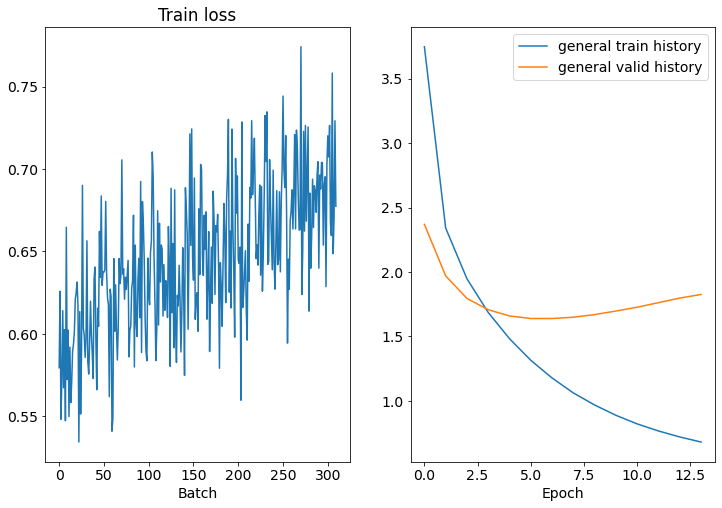

Epoch: 15 | Time: 0m 40s
	Train Loss: 0.646 | Train PPL:   1.907
	 Val. Loss: 1.867 |  Val. PPL:   6.467


In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/NLP_IRA/transformer_model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)

    lr_scheduler.step(train_history[-1])

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


In [ ]:
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.816 | Test PPL:   6.150 |


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP_IRA/transformer_model.pt'))

<All keys matched successfully>

In [ ]:
bleu_score_pretrained = calculate_bleu_transformer(test_data, SRC, TRG, model, device, greedy=True)

print(f'BLEU score = {bleu_score_pretrained *100:.2f}')

BLEU score = 28.52


Примеры перевода:

In [ ]:
%%time
for example_idx in range(10):

  src = vars(train_data.examples[example_idx])['src']
  trg = vars(train_data.examples[example_idx])['trg']
  pred_trg, _ = translate_sentence_transformer(src, SRC, TRG, model, device, greedy=True)

  print('Text: {}'.format(' '.join(src)))
  print('Original translation: {}'.format(' '.join(trg)))
  print('Generated translation: {}'.format(' '.join(pred_trg[:-1])))
  print()

Text: в 1 , 9 км находится свято - троицкий кафедральный собор .
Original translation: the apartment is 1 . 9 km from trinity cathedral .
Generated translation: the apartment is 1 . 9 km from trinity cathedral .

Text: на территории отеля обустроена бесплатная частная парковка и работает прокат велосипедов .
Original translation: free private parking and bike rental are available on site .
Generated translation: free private parking is available on site and bike hire is available at the hotel .

Text: дом для отпуска degnevangen blåvand iv с крытым бассейном площадью 24 квадратных метра находится в поселке блованн , в 200 метрах от магазина и ресторана .
Original translation: offering a 24 square meters indoor swimming pool , holiday home degnevangen blåvand iv is located in blåvand , 200 m from the shop and restaurant .
Generated translation: holiday home <unk> blåvand iv is located in blåvand , 200 metres from the shop , and there is a restaurant , 200 metres from the shop .

Text: г

Удачные примеры переводов:

 - в распоряжении гостей общий лаундж - there is a shared lounge at the property
 - среди дополнительных удобств — письменный стол и постельное белье - extras include a desk and bed linen


## **Self-critical policy gradient**

Теперь попробуем дообучить полученную модель с помощью Self-critical policy gradient.

In [ ]:
def translate_batch(model, src, trg, device=device, greedy=False):
    batch_size = trg.shape[1]
    max_len = trg.shape[0]

    logits, _ = model(src, trg)
    if greedy:
        res = logits.argmax(dim=-1)
    else:
        res = torch.zeros(max_len, batch_size, dtype=torch.int, device=device)
        probs = F.softmax(logits, dim=-1)

        for i in range(max_len):
           res[i, :] = torch.multinomial(probs[i, :, :], 1)[:, 0]
    return res, F.log_softmax(logits, dim=-1) # logits


In [ ]:
def get_sentense_bleu(true_text, pred_text):
    return sentence_bleu([true_text], pred_text)

In [ ]:
def compute_reward(true_text, pred_text):
    scores = list(map(get_sentense_bleu, true_text, pred_text))
    return torch.tensor(scores)

In [ ]:
def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data
    y_tensor = y_tensor.to(dtype=torch.long).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims, device=y.device).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return y_one_hot

In [ ]:
def infer_mask(seq, eos_ix, batch_first=False, include_eos=True, dtype=torch.float):
    """
    compute length given output indices and eos code
    :param seq: tf matrix [time,batch] if batch_first else [batch,time]
    :param eos_ix: integer index of end-of-sentence token
    :param include_eos: if True, the time-step where eos first occurs is has mask = 1
    :returns: lengths, int32 vector of shape [batch]
    """
    assert seq.dim() == 2
    is_eos = (seq == eos_ix).to(dtype=torch.float)
    if include_eos:
        if batch_first:
            is_eos = torch.cat((is_eos[:,:1]*0, is_eos[:, :-1]), dim=1)
        else:
            is_eos = torch.cat((is_eos[:1,:]*0, is_eos[:-1, :]), dim=0)
    count_eos = torch.cumsum(is_eos, dim=1 if batch_first else 0)
    mask = count_eos == 0
    return mask.to(dtype=dtype)

In [ ]:
def scst_objective_on_batch(model, src, trg, TRG, device=device):
    """ Compute pseudo-loss for policy gradient given a batch of sources """

    input_sequence = [get_text(x, TRG.vocab) for x in trg.cpu().numpy()]

    sample_translations, sample_logp = translate_batch(model, src, trg, device=device, greedy=False)
    greedy_translations, greedy_logp = translate_batch(model, src, trg, device=device, greedy=True)

    sample_text = [get_text(x, TRG.vocab) for x in sample_translations.detach().cpu().numpy()]#.T]
    greedy_text = [get_text(x, TRG.vocab) for x in greedy_translations.detach().cpu().numpy()]#.T]


    rewards = compute_reward(input_sequence, sample_text)
    baseline = compute_reward(input_sequence, greedy_text)

    advantage = (rewards - baseline).float().to(device)


    logp_sample = torch.sum(to_one_hot(sample_translations, n_dims=len(TRG.vocab)) * sample_logp, dim=-1)

    J = logp_sample * advantage[:, None]
    
    mask = infer_mask(sample_translations, TRG.vocab[TRG.eos_token])
    loss = - torch.sum(J * mask) / torch.sum(mask)

    entropy = - torch.sum(torch.exp(sample_logp) * sample_logp, dim=-1)
    reg = - 0.001 * torch.sum(entropy * mask) / torch.sum(mask)

    return loss + reg, torch.sum(entropy * mask) / torch.sum(mask)

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
base_blue = bleu_score_pretrained #bleu_score, полученный при обучении с учителем

N_EPOCHS = 50
BATCH_SIZE = 64
epoch_loss = []

for epoch in range(N_EPOCHS):
    for i, batch in tqdm.tqdm(enumerate(train_iterator)):
        model.train()
        src = batch.src
        trg = batch.trg

        loss, ent = scst_objective_on_batch(model, src, trg, TRG, device)
        epoch_loss.append(loss.item())
        
        loss.backward()
        opt.step()
        opt.zero_grad()

    BLEU_score = calculate_bleu_transformer(valid_data, SRC, TRG, model, device, greedy=True)

    if BLEU_score > base_blue:
        torch.save(model.state_dict(), '/content/drive/MyDrive/NLP_IRA/transformer_model_policy_grad.pt')
        base_blue = BLEU_score



    print('epoch: {}'.format(epoch))
    print('epoch_loss: {}'.format(np.array(epoch_loss).mean()))
    print('val_blue: {}'.format(BLEU_score))

313it [01:09,  4.47it/s]


epoch: 0
epoch_loss: -0.8967555932724438
val_blue: 0.2883634373842531


313it [01:09,  4.50it/s]


epoch: 1
epoch_loss: -0.8921931734481178
val_blue: 0.28764510223633066


313it [01:10,  4.47it/s]


epoch: 2
epoch_loss: -0.8833317555748997
val_blue: 0.28827781070653763


313it [01:10,  4.45it/s]


epoch: 3
epoch_loss: -0.8762956823641881
val_blue: 0.2878111416413796


313it [01:09,  4.49it/s]


epoch: 4
epoch_loss: -0.8668573310009587
val_blue: 0.2913731114763939


313it [01:09,  4.48it/s]


epoch: 5
epoch_loss: -0.8597512839320368
val_blue: 0.28853492529877955


313it [01:10,  4.41it/s]


epoch: 6
epoch_loss: -0.8520137144517049
val_blue: 0.29098385761323636


313it [01:09,  4.48it/s]


epoch: 7
epoch_loss: -0.8473604680797734
val_blue: 0.29269712225595595


313it [01:10,  4.46it/s]


epoch: 8
epoch_loss: -0.8433633443731173
val_blue: 0.29049425358903114


313it [01:10,  4.47it/s]


epoch: 9
epoch_loss: -0.8371300926604591
val_blue: 0.29069752133836324


313it [01:09,  4.50it/s]


epoch: 10
epoch_loss: -0.8307802338794744
val_blue: 0.29104948434722083


313it [01:10,  4.46it/s]


epoch: 11
epoch_loss: -0.827286041876315
val_blue: 0.2892760631384328


313it [01:09,  4.51it/s]


epoch: 12
epoch_loss: -0.8222047033767554
val_blue: 0.28884313717172416


313it [01:09,  4.50it/s]


epoch: 13
epoch_loss: -0.8186217938137076
val_blue: 0.28815301460389353


313it [01:10,  4.46it/s]


epoch: 14
epoch_loss: -0.814146011248945
val_blue: 0.29019810231120724


313it [01:09,  4.52it/s]


epoch: 15
epoch_loss: -0.809539877467405
val_blue: 0.28958504187619444


313it [01:09,  4.49it/s]


epoch: 16
epoch_loss: -0.8059922692314662
val_blue: 0.28841289086236727


313it [01:10,  4.44it/s]


epoch: 17
epoch_loss: -0.8016273858310654
val_blue: 0.2908779350390612


313it [01:09,  4.48it/s]


epoch: 18
epoch_loss: -0.7983915696820432
val_blue: 0.29270936730061897


313it [01:10,  4.47it/s]


epoch: 19
epoch_loss: -0.7950520233676647
val_blue: 0.29214065553254326


313it [01:09,  4.48it/s]


epoch: 20
epoch_loss: -0.7929394339796036
val_blue: 0.2918631586818155


313it [01:09,  4.49it/s]


epoch: 21
epoch_loss: -0.7899952546506471
val_blue: 0.2906203033018896


313it [01:10,  4.45it/s]


epoch: 22
epoch_loss: -0.7862169335870912
val_blue: 0.2913670344187464


313it [01:09,  4.49it/s]


epoch: 23
epoch_loss: -0.7830905769242488
val_blue: 0.2920497443818298


313it [01:09,  4.49it/s]


epoch: 24
epoch_loss: -0.779817864889154
val_blue: 0.2901379759068582


313it [01:10,  4.44it/s]


epoch: 25
epoch_loss: -0.776636948888221
val_blue: 0.2893755163929295


313it [01:09,  4.49it/s]


epoch: 26
epoch_loss: -0.7735681460885773
val_blue: 0.29117333810150237


313it [01:09,  4.49it/s]


epoch: 27
epoch_loss: -0.7710590946149304
val_blue: 0.2916100311318573


313it [01:10,  4.45it/s]


epoch: 28
epoch_loss: -0.7681350404731342
val_blue: 0.29124044012525396


313it [01:09,  4.50it/s]


epoch: 29
epoch_loss: -0.7657898092993533
val_blue: 0.29365940979785693


313it [01:09,  4.47it/s]


epoch: 30
epoch_loss: -0.7632659565391312
val_blue: 0.2922946776384199


313it [01:09,  4.50it/s]


epoch: 31
epoch_loss: -0.7601680597528434
val_blue: 0.29052775208056386


313it [01:09,  4.49it/s]


epoch: 32
epoch_loss: -0.757768323497304
val_blue: 0.2903263698432181


313it [01:10,  4.47it/s]


epoch: 33
epoch_loss: -0.754938719805706
val_blue: 0.291600883142227


313it [01:08,  4.54it/s]


epoch: 34
epoch_loss: -0.7519083023588171
val_blue: 0.2936314395406005


313it [01:09,  4.50it/s]


epoch: 35
epoch_loss: -0.7492561708668952
val_blue: 0.2923952552447235


313it [01:10,  4.47it/s]


epoch: 36
epoch_loss: -0.7466903074967224
val_blue: 0.29357303239507326


313it [01:09,  4.49it/s]


epoch: 37
epoch_loss: -0.7446591768314182
val_blue: 0.29613692967777705


313it [01:09,  4.50it/s]


epoch: 38
epoch_loss: -0.7427033175472996
val_blue: 0.2928799002138882


313it [01:10,  4.43it/s]


epoch: 39
epoch_loss: -0.7409578106404779
val_blue: 0.29431317761759196


313it [01:09,  4.50it/s]


epoch: 40
epoch_loss: -0.7395742909380013
val_blue: 0.29187308141703644


313it [01:09,  4.48it/s]


epoch: 41
epoch_loss: -0.7376985513688349
val_blue: 0.291636030650713


313it [01:09,  4.51it/s]


epoch: 42
epoch_loss: -0.7353890086065759
val_blue: 0.29098955438248336


313it [01:09,  4.52it/s]


epoch: 43
epoch_loss: -0.7340783280372671
val_blue: 0.29326191315539635


313it [01:10,  4.44it/s]


epoch: 44
epoch_loss: -0.7328534088756414
val_blue: 0.2933437115121361


313it [01:09,  4.50it/s]


epoch: 45
epoch_loss: -0.7314613545345819
val_blue: 0.2957521747905877


313it [01:08,  4.54it/s]


epoch: 46
epoch_loss: -0.7300245941625269
val_blue: 0.2943346850369033


313it [01:10,  4.45it/s]


epoch: 47
epoch_loss: -0.7287053289546516
val_blue: 0.29282769193359626


313it [01:09,  4.50it/s]


epoch: 48
epoch_loss: -0.7267785355066891
val_blue: 0.29358355378152157


313it [01:09,  4.50it/s]


epoch: 49
epoch_loss: -0.7251352954910586
val_blue: 0.29307971618560896


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP_IRA/transformer_model_policy_grad.pt'))

<All keys matched successfully>

In [ ]:
BLEU_score = calculate_bleu_transformer(test_data, SRC, TRG, model, device, greedy=True)

print(f'BLEU score = {BLEU_score*100:.2f}')

BLEU score = 29.34


Видим, что BLUE увеличился на 0.82 за счет применения self-critical policy gradient.

Примеры переводов:

In [ ]:
for example_idx in range(10):

  src = vars(train_data.examples[example_idx])['src']
  trg = vars(train_data.examples[example_idx])['trg']
  pred_trg, _ = translate_sentence_transformer(src, SRC, TRG, model, device, greedy=True)

  print('Text: {}'.format(' '.join(src)))
  print('Original translation: {}'.format(' '.join(trg)))
  print('Generated translation: {}'.format(' '.join(pred_trg[:-1])))
  print()

Text: в 1 , 9 км находится свято - троицкий кафедральный собор .
Original translation: the apartment is 1 . 9 km from trinity cathedral .
Generated translation: the apartment is 1 . 9 km from trinity cathedral .

Text: на территории отеля обустроена бесплатная частная парковка и работает прокат велосипедов .
Original translation: free private parking and bike rental are available on site .
Generated translation: free private parking is available on site and bike hire is available at the hotel .

Text: дом для отпуска degnevangen blåvand iv с крытым бассейном площадью 24 квадратных метра находится в поселке блованн , в 200 метрах от магазина и ресторана .
Original translation: offering a 24 square meters indoor swimming pool , holiday home degnevangen blåvand iv is located in blåvand , 200 m from the shop and restaurant .
Generated translation: holiday home <unk> blåvand iv is located in blåvand , 200 metres from the shop , and a restaurant .

Text: гости могут приготовить себе еду на к